# Q1

## getting the data

In [16]:
import kagglehub
path=kagglehub.dataset_download("mohamad1dehqani/persian-spam-email")

In [1]:
import pandas as pd

raw_data=pd.read_csv('./data/emails.csv')

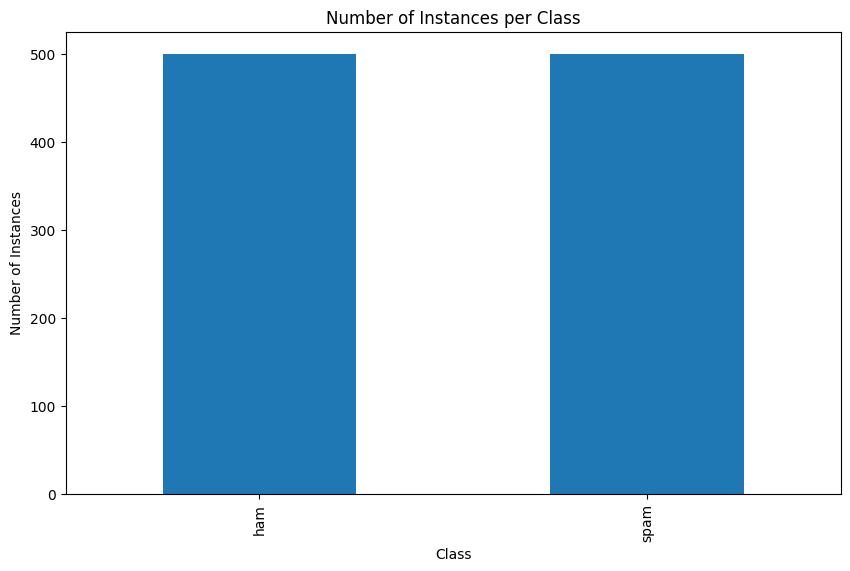

In [2]:
import matplotlib.pyplot as plt

class_counts = raw_data['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Class')
plt.show()


## preprocess

In [38]:
raw_data['text']

0      ﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...
1      ﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...
2      ﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...
3      ﻿با سلام  و احترام\nضمن تقدیر از مسولین محترم ...
4      ﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...
                             ...                        
995    ﻿\nبسمه تعالی\n\nسازمان زیباسازی شهرداری استان...
996    ﻿\n\nبه مناسبت فرا رسیدن میلاد دخت پیامبر گرام...
997    ﻿\nدرود هموطن من\n\n \n\nتست رایگان   \n\n    ...
998    ﻿\n\n    *درج **لینک  در 8700 وبلاگ\n    *\n\n...
999    ﻿\nسلام به دوستان عزیز\nشما هم میتوانید از این...
Name: text, Length: 1000, dtype: object

In [3]:
import re

url_pattern = r'http[s]?://\S+|www\.\S+|WWW\.\S+|Www\.\S+|WwW\.\S+'
email_pattern = r'\b[A-Za-z0-9\*._%+-]+@[A-Za-z0-9\*.-]+\.[A-Z|a-z]{2,}\b'
phone_pattern = r'\d{11}|(\d{4}[ -\*]\d{3}[ -\*]\d{4})|\d{3}[-]+\d{8}|\d{3}[ ]+\d{8}|[(]\d{3}[) ]+\d{8}|\d{8}'
combined_pattern = f'({url_pattern})|({email_pattern})|({phone_pattern})'

def clean_text(text):
    cleaned_text = re.sub(r'(.)\1+', r'\1', text)
    return re.sub(combined_pattern, '', cleaned_text)


raw_data['text'] = raw_data['text'].apply(clean_text)

In [4]:
with open('./data/persian_stopwords', 'r', encoding='utf-8') as f:
    persian_stop_words = f.read().splitlines()

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in persian_stop_words]
    return ' '.join(filtered_words)

raw_data['text'] = raw_data['text'].apply(remove_stopwords)

## tokenizing

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model.hidden_size=120
texts = raw_data['text'].tolist()
inputs = tokenizer(texts, padding='max_length', max_length=32, return_tensors="pt", truncation=True)

with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs.last_hidden_state

In [7]:
hidden_states.shape

torch.Size([1000, 32, 768])

In [11]:
import torch
from sklearn.decomposition import PCA

flattened_tensor = hidden_states.view(-1, 768).numpy()

pca = PCA(n_components=120)
reduced_tensor = pca.fit_transform(flattened_tensor)

vectorized_data = torch.tensor(reduced_tensor).view(1000, 32, 120)

print(vectorized_data.shape)

torch.Size([1000, 32, 120])


## Preparing Data for Training

In [12]:
labels = raw_data['label'].values.copy()
for i in range(len(labels)):
    if labels[i]=='ham':
        labels[i]=0
    else:
        labels[i]=1

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_data, labels, test_size=0.3, random_state=42)

In [55]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [84]:
X_train.shape

torch.Size([700, 32, 120])

## Grid Search

In [118]:
import itertools
import tensorflow as tf

batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
optimizers = {'Adam': tf.keras.optimizers.Adam, 'SGD': tf.keras.optimizers.SGD}

def grid_search(creator_func):
    best_accuracy = 0
    best_params = {}
    results = []

    for batch_size, learning_rate, (opt_name, optimizer) in itertools.product(batch_sizes, learning_rates, optimizers.items()):
        model = creator_func(optimizer, learning_rate)
        
        history = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=5,
                            verbose=0)
        
        final_accuracy = history.history['accuracy'][-1]
        results.append((batch_size, learning_rate, opt_name, final_accuracy))
        
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'optimizer': opt_name}

    print("best params:")
    print(best_params)


## Training CNN LSTM:

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM

def create_cnn_lstm(optimizer, learning_rate):
    cnn_lstm_model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, dropout=0.2),
        Dense(1, activation='sigmoid')
    ])

    model_optimizer = optimizer(learning_rate=learning_rate)
    cnn_lstm_model.build(input_shape=(None, 32, 120))
    cnn_lstm_model.compile(optimizer=model_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_lstm_model

In [119]:
grid_search(create_cnn_lstm)

best params:
{'batch_size': 8, 'learning_rate': 0.001, 'optimizer': 'Adam'}


In [144]:
cnn_lstm_model=create_cnn_lstm(optimizers['Adam'], 0.001)
cnn_lstm_model.summary()

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)              │ (None, 30, 32)         │        11,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,449 (142.38 KB)

 Trainable params: 36,449 (142.38 KB)

 Non-trainable params: 0 (0.00 B)

In [145]:
cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_train[:len(X_train)//5], y_train[:len(y_train)//5]))

loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7200 - loss: 0.4827 - val_accuracy: 0.9571 - val_loss: 0.1254
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9724 - loss: 0.1057 - val_accuracy: 0.9500 - val_loss: 0.1056
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9793 - loss: 0.0539 - val_accuracy: 0.9786 - val_loss: 0.0536
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9922 - loss: 0.0287 - val_accuracy: 0.9929 - val_loss: 0.0381
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9922 - loss: 0.0242 - val_accuracy: 0.9929 - val_loss: 0.0302
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9891 - loss: 0.0345 - val_accuracy: 0.9929 - val_loss: 0.0284
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9918 - loss: 0.0356 - val_accuracy: 0.9857 - val_loss: 0.0270
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9853 - loss: 0.0422 - val_accuracy: 0.9857 - val_loss:

## Training CNN:

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

def create_cnn(optimizer, learning_rate):
    cnn_model = Sequential([
        # Embedding(input_dim=6000, output_dim=64,embeddings_initializer='uniform'),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])


    model_optimizer = optimizer(learning_rate=learning_rate)
    cnn_model.build(input_shape=(None, 32, 120))
    cnn_model.compile(optimizer=model_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model


In [129]:
grid_search(create_cnn)

best params:
{'batch_size': 8, 'learning_rate': 0.001, 'optimizer': 'Adam'}


In [130]:
cnn_model=create_cnn(optimizers['Adam'], 0.001)
cnn_model.summary()

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_55 (Conv1D)              │ (None, 30, 32)         │        11,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
cnn_model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_train[:len(X_train)//5], y_train[:len(y_train)//5]))

loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6992 - loss: 0.5835 - val_accuracy: 0.9929 - val_loss: 0.0618
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0389 - val_accuracy: 1.0000 - val_loss: 0.0168
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss:

## Training LSTM

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout

def create_lstm(optimizer, learning_rate):
    lstm_model = Sequential([
        LSTM(64, dropout=0.2, stateful=False, kernel_initializer='glorot_uniform'),
        Dense(1, activation='sigmoid')
    ])



    model_optimizer = optimizer(learning_rate=learning_rate)
    lstm_model.build(input_shape=(None, 32, 120))
    lstm_model.compile(optimizer=model_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model

In [139]:
grid_search(create_lstm)

best params:
{'batch_size': 8, 'learning_rate': 0.001, 'optimizer': 'Adam'}


In [140]:
lstm_model=create_cnn_lstm(optimizers['Adam'], 0.001)
lstm_model.summary()

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_59 (Conv1D)              │ (None, 30, 32)         │        11,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_59 (MaxPooling1D) │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,449 (142.38 KB)

 Trainable params: 36,449 (142.38 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
lstm_model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2)

loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7556 - loss: 0.5350 - val_accuracy: 0.9643 - val_loss: 0.1141
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9695 - loss: 0.1169 - val_accuracy: 0.9786 - val_loss: 0.1000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9700 - loss: 0.0834 - val_accuracy: 0.9714 - val_loss: 0.1096
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9808 - loss: 0.0479 - val_accuracy: 0.9643 - val_loss: 0.1283
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9857 - loss: 0.0576 - val_accuracy: 0.9786 - val_loss: 0.0901
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9871 - loss: 0.0357 - val_accuracy: 0.9714 - val_loss: 0.1232
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9922 - loss: 0.0146 - val_accuracy: 0.9786 - val_loss: 0.1224
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0166 - val_accuracy: 0.9786 - val_loss

## Eval:

In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_metrics(model):
    y_pred = model.predict(X_test) > 0.5

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


In [148]:
print("LSTM:")
get_metrics(lstm_model)
print("\nCNN:")
get_metrics(cnn_model)
print("\nCNN_LSTM:")
get_metrics(cnn_lstm_model)

LSTM:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.9667
Precision: 0.9730
Recall: 0.9600
F1-Score: 0.9664
ROC AUC: 0.9667

CNN:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.9533
Precision: 0.9474
Recall: 0.9600
F1-Score: 0.9536
ROC AUC: 0.9533

CNN_LSTM:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.9767
Precision: 0.9735
Recall: 0.9800
F1-Score: 0.9767
ROC AUC: 0.9767


## Extra

### bag of words

In [268]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

texts = raw_data['text'].tolist()

vectorizer = CountVectorizer()
count_vectorized = vectorizer.fit_transform(texts)

bag_of_words = pd.DataFrame(count_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
bag_of_words.sample(n=20, axis=1)


,بدنرفع,علویه,فيلسوفي,گرامافون,برنامه,username,سازگار,فيروز,دانم,pin,تقریبی,دوخته,تراز,مس,میشنوم,تشكر,نصاب,درايور,صحبتهات,غني
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### reshaping inputs to be 2D

In [164]:
X_train_2d =  X_train.reshape(X_train.shape[0], -1)
X_test_2d =  X_test.reshape(X_test.shape[0], -1)

In [173]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_metrics_2D(model):
    y_pred = model.predict(X_test_2d) > 0.5

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


### Methods

In [199]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_2d, y_train)

DecisionTreeClassifier()

In [194]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train_2d, y_train)

LogisticRegression()

In [193]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_2d, y_train)

RandomForestClassifier()

In [191]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=100)
et_model.fit(X_train_2d, y_train)

ExtraTreesClassifier()

### Eval:

In [200]:
print("decision tree:")
get_metrics_2D(dt_model)
print("\nlogistic regression:")
get_metrics_2D(lr_model)
print("\nrandom forest:")
get_metrics_2D(rf_model)
print("\nExtra trees:")
get_metrics_2D(et_model)

decision tree:
Accuracy: 0.9033
Precision: 0.8854
Recall: 0.9267
F1-Score: 0.9055
ROC AUC: 0.9033

logistic regression:
Accuracy: 0.9667
Precision: 0.9667
Recall: 0.9667
F1-Score: 0.9667
ROC AUC: 0.9667

random forest:
Accuracy: 0.9367
Precision: 0.9281
Recall: 0.9467
F1-Score: 0.9373
ROC AUC: 0.9367

Extra trees:
Accuracy: 0.9467
Precision: 0.9241
Recall: 0.9733
F1-Score: 0.9481
ROC AUC: 0.9467
